# EmoInt dataset for emotion detection in lyrics

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EmoInt-dataset-for-emotion-detection-in-lyrics" data-toc-modified-id="EmoInt-dataset-for-emotion-detection-in-lyrics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EmoInt dataset for emotion detection in lyrics</a></span><ul class="toc-item"><li><span><a href="#EmoInt-statistics" data-toc-modified-id="EmoInt-statistics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>EmoInt statistics</a></span></li><li><span><a href="#Merge-with-MoodyLyrics" data-toc-modified-id="Merge-with-MoodyLyrics-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Merge with MoodyLyrics</a></span></li></ul></li><li><span><a href="#Features-Selection" data-toc-modified-id="Features-Selection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Selection</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Extra-test-set" data-toc-modified-id="Extra-test-set-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Extra test set</a></span></li></ul></li><li><span><a href="#k-Nearest-Neighbour" data-toc-modified-id="k-Nearest-Neighbour-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>k-Nearest Neighbour</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#Gradient-Boost" data-toc-modified-id="Gradient-Boost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Gradient Boost</a></span></li><li><span><a href="#Artificial-Neural-Network" data-toc-modified-id="Artificial-Neural-Network-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Artificial Neural Network</a></span><ul class="toc-item"><li><span><a href="#Playlist-Classification" data-toc-modified-id="Playlist-Classification-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Playlist Classification</a></span></li></ul></li><li><span><a href="#Naive-Bayes-Classifier" data-toc-modified-id="Naive-Bayes-Classifier-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Naive Bayes Classifier</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>References</a></span></li></ul></div>

In [1]:
import spacy
import os
import sys

import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from utils.datasets import load_dataset_from_path, split_train_validation

emotion_labels = ['happy', 'sad', 'angry', 'relaxed']

In [2]:
def plot_confusion_matrix(cm, classes = emotion_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Read extra test set
extra_test_path = './datasets/extra_test.csv'
extra_test = pd.read_csv(extra_test_path)

Existing emotion datasets are mainly annotated categorically without an indication of degree of emotion. EmoInt, instead, provides several tweets annotated according to an emotion (anger, fear, joy, sadness) and to the degree at which the emotion is expressed in text.

It is important to mention that EmoInt was manually annotated, using [Best-Worst Scaling](https://nparc.nrc-cnrc.gc.ca/eng/view/fulltext/?id=b132b0af-2ae0-4964-ac3a-493e7292a37a) (BWS), an annotation scheme shown to obtain very reliable scores.

For our purpose, we will consider each tweet to be like a lyric and, on top of that, we will perform our feature engineering using spaCy and the other tools we used so far.

Our original dataset, MoodyLyrics, contains "happy", "sad", "angry" and "relaxed" as labels. Therefore, in order to perform a sort of interjection with EmoInt, we will just use the tweets corresponding to the anger, joy and sadness emotions.

The remaining part of this notebook assumes that we have already parsed EmoInt dataset in a .csv file which we can use to train some machine learning models as we did when we performed our feature engineering on lyrics. For more information about how this .csv was generated, please refer to the `src/emoint_parser.py` script.

## EmoInt statistics

As EmoInt provide intensity levels together with emotion labels, we decided to take into account only those tweets for which the intensity was greater that 0.50 (50%). Also, we dropped hashtags a remove the tag characters (e.g. "Hey @MrTwitter how are you? #cool" became "Hey MrTwitter how are you?") because we will have to compare those tweets with songs and songs do not have those kind of things. Also, this sort of preprocessing should maximize the chances that everything is recognized properly by spaCy's POS tagger.

In [4]:
emoint = pd.read_csv('datasets/emoint_featurized.csv')

In [5]:
emoint.head(5)

,ID,ARTIST,SONG_TITLE,LYRICS_VECTOR,TITLE_VECTOR,LINE_COUNT,WORD_COUNT,ECHOISMS,SELFISH_DEGREE,DUPLICATE_LINES,...,PROPN_FREQUENCIES,PUNCT_FREQUENCIES,SCONJ_FREQUENCIES,SYM_FREQUENCIES,VERB_FREQUENCIES,X_FREQUENCIES,SPACE_FREQUENCIES,SENTIMENT,SUBJECTIVITY,EMOTION
0,EmoInt_30000,EmoInt,30000,[-1.26710683e-01 1.60194725e-01 -1.36762261e-...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,16,0.0,0.000000,0.0,...,0.125000,0.187500,0.0,0.0,0.250000,0.0,0.000000,0.379167,0.366667,happy
1,EmoInt_30001,EmoInt,30001,[-6.28133714e-02 1.90393195e-01 -1.95530921e-...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,19,0.0,1.000000,0.0,...,0.000000,0.052632,0.0,0.0,0.263158,0.0,0.000000,0.279167,0.500000,happy
2,EmoInt_30002,EmoInt,30002,[ 9.66307223e-02 2.91245524e-02 -1.42218113e-...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,11,0.0,0.000000,0.0,...,0.363636,0.000000,0.0,0.0,0.181818,0.0,0.090909,-0.400000,0.400000,happy
3,EmoInt_30003,EmoInt,30003,[-1.13483094e-01 3.13860744e-01 -2.05740720e-...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,23,0.0,0.200000,0.0,...,0.043478,0.304348,0.0,0.0,0.173913,0.0,0.000000,0.470000,0.490000,happy
4,EmoInt_30004,EmoInt,30004,[ 3.85632203e-03 2.41273686e-01 -1.58885673e-...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,22,0.0,0.666667,0.0,...,0.045455,0.136364,0.0,0.0,0.227273,0.0,0.000000,0.400000,0.350000,happy


We used the same columns naming convention we used in the past notebooks with MoodyLyrics just for compatibility reasons (we will have to put them together). Since tweets do not have title, the `TITLE_VECTOR` was just left there as a vector of 0s, with the same shape of the `LYRICS_VECTOR`.

## Merge with MoodyLyrics
Let's now merge EmoInt and MoodyLyrics featurized datasets in order to be able to proceed with further analysis.

In [6]:
path = 'datasets/moodylyrics_featurized.csv'

In [7]:
moodylyrics = pd.read_csv(path)

In [8]:
selected_columns = [
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY',
   'EMOTION'
]

In [9]:
moodylyrics = moodylyrics[selected_columns]
emoint = emoint[selected_columns]

In [10]:
dataset = emoint.append(moodylyrics)

In [11]:
dataset.describe()

,WORD_COUNT,ECHOISMS,SELFISH_DEGREE,DUPLICATE_LINES,VERB_PRESENT,VERB_PAST,VERB_FUTURE,ADJ_FREQUENCIES,PUNCT_FREQUENCIES,SENTIMENT,SUBJECTIVITY
count,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000
mean,115.487675,0.001933,0.257160,0.046589,0.681493,0.223661,0.032797,0.103892,0.097045,0.097237,0.484382
std,123.785535,0.014999,0.307920,0.062358,0.327669,0.276698,0.102555,0.080279,0.128123,0.332293,0.284253
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,16.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.051323,0.016854,-0.045387,0.313378
50%,64.000000,0.000000,0.142857,0.000000,0.769231,0.125000,0.000000,0.090909,0.068182,0.050000,0.527234
75%,198.000000,0.000000,0.451455,0.086786,1.000000,0.333333,0.000000,0.142857,0.135135,0.322120,0.653667
max,1149.000000,0.341463,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,2.777778,1.000000,1.000000


# Features Selection

Based on our experience with previous models and feature engineering strategies, we believe that building models using all our available features is a waste of time. We already noticed that the models which achieved better results were those using just the content of the lyrics. Therefore we will work on just the content of our input texts (either lyrics or tweets) plus some additional features. Among all the available features we decided to pick the followings:
- SELFISH_DEGREE
- VERB_PRESENT
- VERB_PAST
- VERB_FUTURE

In fact we believe that we can not use other features which may seem to be useful for our purpose ,e.g. "RHYMES", because, as we are considering a broader dataset, those kind of features are not general enough (not suitable for tweets).

In [12]:
dataset = dataset[selected_columns]

In [13]:
dataset.head(5)

,LYRICS_VECTOR,WORD_COUNT,ECHOISMS,SELFISH_DEGREE,DUPLICATE_LINES,IS_TITLE_IN_LYRICS,VERB_PRESENT,VERB_PAST,VERB_FUTURE,ADJ_FREQUENCIES,PUNCT_FREQUENCIES,SENTIMENT,SUBJECTIVITY,EMOTION
0,[-1.26710683e-01 1.60194725e-01 -1.36762261e-...,16,0.0,0.000000,0.0,False,0.750000,0.250000,0.0,0.062500,0.187500,0.379167,0.366667,happy
1,[-6.28133714e-02 1.90393195e-01 -1.95530921e-...,19,0.0,1.000000,0.0,False,0.666667,0.333333,0.0,0.105263,0.052632,0.279167,0.500000,happy
2,[ 9.66307223e-02 2.91245524e-02 -1.42218113e-...,11,0.0,0.000000,0.0,False,0.500000,0.500000,0.0,0.000000,0.000000,-0.400000,0.400000,happy
3,[-1.13483094e-01 3.13860744e-01 -2.05740720e-...,23,0.0,0.200000,0.0,False,0.750000,0.250000,0.0,0.173913,0.304348,0.470000,0.490000,happy
4,[ 3.85632203e-03 2.41273686e-01 -1.58885673e-...,22,0.0,0.666667,0.0,False,1.000000,0.000000,0.0,0.090909,0.136364,0.400000,0.350000,happy


# Modeling

Before starting we should flatten the dataset's features which are vectors at the moment (title vector and content vector). Let's do that

In [14]:
X_vect = list()
for (i, row) in dataset.drop('EMOTION', axis=1).iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)

In [15]:
y = dataset['EMOTION'].as_matrix().T

In [16]:
print(X_vect.shape)
print(y.shape)

(4706, 312)
(4706,)


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size = 0.2, random_state = 0)

As we can see, we will have 4706 entries in our dataset, each of them having 312 different features.

### Extra test set

In [18]:
extra_test = extra_test[selected_columns]

In [19]:
tmp_df = extra_test.drop(['EMOTION'], axis=1)
X_test_extra = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_test_extra.append(np.array(sub_list))
X_test_extra = np.array(X_test_extra)

In [20]:
y_test_extra = extra_test['EMOTION'].as_matrix().T

## k-Nearest Neighbour

In [159]:
from sklearn.neighbors import KNeighborsClassifier

ks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for k in ks:
    # Build model
    clf = KNeighborsClassifier(n_neighbors=k, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
    # Evaluate accuracy
    scores = cross_val_score(clf, X_vect, y, cv=10)
    print('Accuracy for k=%d: %0.2f (+/- %0.2f)' % (k, scores.mean(), scores.std() * 1.96))

Accuracy for k=1: 0.48 (+/- 0.10)
Accuracy for k=3: 0.46 (+/- 0.09)
Accuracy for k=5: 0.46 (+/- 0.10)
Accuracy for k=7: 0.46 (+/- 0.11)
Accuracy for k=9: 0.45 (+/- 0.13)
Accuracy for k=11: 0.44 (+/- 0.13)
Accuracy for k=13: 0.44 (+/- 0.13)
Accuracy for k=15: 0.43 (+/- 0.15)
Accuracy for k=17: 0.43 (+/- 0.16)
Accuracy for k=19: 0.44 (+/- 0.17)
Accuracy for k=21: 0.44 (+/- 0.18)


## SVM

In [19]:
def parameters_grid_search(classifier, params, x, y, cv=10, verbose=False):
    """
    Grid Search to find best parameters for a certain classifier whose
    performances are evaluated using cross-validation
    """
    gs = GridSearchCV(classifier(), params, cv=cv, n_jobs=-1, verbose=verbose)
    gs.fit(x, y)    
    return (gs.best_estimator_, gs.best_params_, gs.best_score_)

In [21]:
from sklearn.svm import SVC

In [20]:
# Build model
clf = SVC()
# Define the set of parameters we want to test on
params = [
    { 'kernel': ['rbf'], 'C': [ 1 ] }
]

# Perform grid search
svm_best, best_params, best_score = parameters_grid_search(SVC, params, X_vect, y, verbose=1)
print('Parameters:', best_params)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


Parameters: {'kernel': 'rbf', 'C': 1}


In [162]:
svm = SVC(C=1, kernel='rbf')
svm.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy of SVM classifier on test set: 0.48


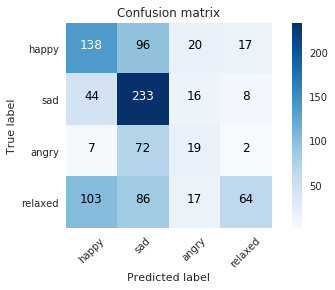

In [163]:
y_pred = svm.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on extra test set: 0.30


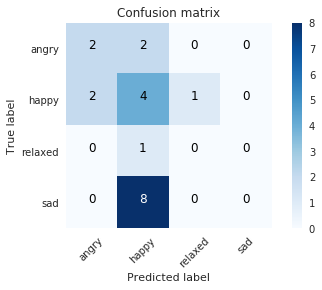

In [166]:
y_pred_extra = svm.predict(X_test_extra)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred_extra), classes=cm_labels)
print('Accuracy of SVM classifier on extra test set: {:.2f}'.format(svm.score(X_test_extra, y_test_extra)))

## Gradient Boost

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

# Build model
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=200)
# Evaluate accuracy
scores = cross_val_score(clf, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.78 (+/- 0.08)


Accuracy of Gradient Boosting classifier on test set: 0.46


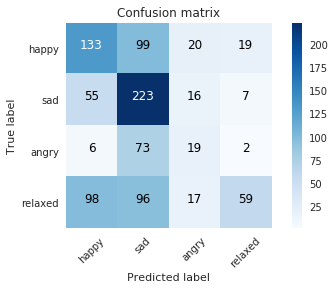

In [44]:
y_pred = svm.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print('Accuracy of Gradient Boosting classifier on test set: {:.2f}'.format(svm.score(X_test, y_test)))

## Artificial Neural Network

In [22]:
from keras.utils import np_utils

## Encode outputs

encoder = LabelEncoder()

encoder.fit(y_train)

encoded_Y_train = encoder.transform(y_train)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_test_extra = encoder.transform(y_test_extra)

y_train_nn = np_utils.to_categorical(encoded_Y_train)
y_test_nn = np_utils.to_categorical(encoded_Y_test)
y_test_extra_nn = np_utils.to_categorical(encoded_Y_test_extra)

Using TensorFlow backend.


In [23]:
cm_labels = encoder.inverse_transform([0, 1, 2, 3])

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [24]:
from sklearn.preprocessing import StandardScaler

## Scale inputs

sc = StandardScaler()

sc.fit(X_train)

X_train_nn = sc.transform(X_train)
X_test_nn = sc.transform(X_test)
X_test_extra_nn = sc.transform(X_test_extra)

In [25]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
    
def build_ann(optimizer='adam', input_size=X_vect.shape[1]):
    classifier = Sequential()
    # Add input layer
    classifier.add(Dense(units = 120, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))
    
    # Add hidden layers
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'softmax', input_dim = input_size))
    classifier.add(Dropout(0.5))
   
    # Add output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))

    # Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [26]:
classifier = build_ann('adam')
classifier.fit(X_train_nn, y_train_nn, batch_size = 256, epochs = 100, verbose=0)
y_pred = classifier.predict(X_test_nn)
y_pred = np.argmax(y_pred,axis=1)

Accuracy: 82.38


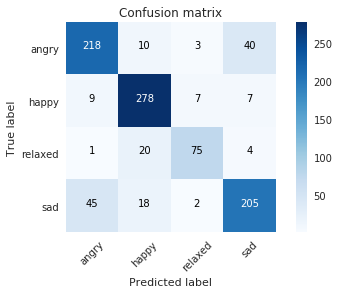

In [27]:
cm = confusion_matrix(encoded_Y_test, y_pred)
plot_confusion_matrix(cm, classes=cm_labels)
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(y_pred)
print('Accuracy: %0.2f' % (accuracy*100))

In [28]:
y_pred_extra = classifier.predict(X_test_extra_nn)
y_pred_extra = np.argmax(y_pred_extra, axis=1)

Accuracy: 50.00


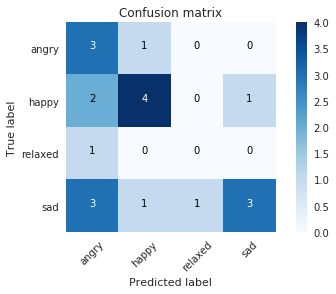

In [29]:
cm = confusion_matrix(encoded_Y_test_extra, y_pred_extra)
plot_confusion_matrix(cm, classes=cm_labels)
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(encoded_Y_test_extra)
print('Accuracy: %0.2f' % (accuracy*100))

### Playlist Classification

In [42]:
import json

n_pl = 5

data = json.load(open('./datasets/mpd.slice.0-999.json'))
playlists = data['playlists'][:n_pl]

In [43]:
from utils.dataset_parsing import *
import utils.sentiment_analysis as sa

In [44]:
def featurize(lyrics, pid, playlist_name, artist, title):
    lyric_doc = nlp(lyrics)
    title_doc = nlp(title)
    lyric = preprocess(lyrics)
    features = feature_extraction(lyric, title)

    freq = features['frequencies'] 
    sentiment = sa.analyse(lyrics)
    elem = [
        pid, playlist_name, 0, artist, title,
        lyric_doc.vector, title_doc.vector,
        features['line_count'], features['word_count'],#get_line_count(lyric), get_word_count(lyric),
        #get_slang_counts(lyric),
        features['echoisms'], features['selfish'],#get_echoisms(lyric), get_selfish_degree(lyric),
        count_duplicate_lines(lyric), features['is_title_in_lyrics'],# (row['Song'], lyric),
        features['rhymes'],#get_rhymes(lyric),
        features['verb_tenses']['present'], features['verb_tenses']['past'], features['verb_tenses']['future'], #verb_freq['present'], verb_freq['past'], verb_freq['future'],
        freq['ADJ'], freq['ADP'], freq['ADV'], freq['AUX'], freq['CONJ'], 
        freq['CCONJ'], freq['DET'], freq['INTJ'], freq['NOUN'], freq['NUM'],
        freq['PART'], freq['PRON'], freq['PROPN'], freq['PUNCT'], freq['SCONJ'],
        freq['SYM'], freq['VERB'], freq['X'], freq['SPACE'],
        # Sentiment analysis stuff
        sentiment[0], sentiment[1]
    ]
    return elem

In [45]:
import lyricwikia

In [46]:
features = list()
for playlist in playlists:
    for track in playlist['tracks']:
        artist = track['artist_name']
        title = track['track_name']
        try:
            lyrics = lyricwikia.get_lyrics(artist, title)
            x = featurize(lyrics, playlist['pid'], 'Test', artist, title)
            features.append(x)
        except lyricwikia.LyricsNotFound:
             continue
    df = pd.DataFrame(features, columns=['PlaylistPid','PlaylistName','TrackUri', 'ArtistName', 'TrackName','LYRICS_VECTOR', 'TITLE_VECTOR', 
            'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
            'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
            'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
            'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
            'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
            'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
            'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES',
            'X_FREQUENCIES', 'SPACE_FREQUENCIES', 
            'SENTIMENT', 'SUBJECTIVITY'])
df.head(3)

,PlaylistPid,PlaylistName,TrackUri,ArtistName,TrackName,LYRICS_VECTOR,TITLE_VECTOR,LINE_COUNT,WORD_COUNT,ECHOISMS,...,PRON_FREQUENCIES,PROPN_FREQUENCIES,PUNCT_FREQUENCIES,SCONJ_FREQUENCIES,SYM_FREQUENCIES,VERB_FREQUENCIES,X_FREQUENCIES,SPACE_FREQUENCIES,SENTIMENT,SUBJECTIVITY
0,0,Test,0,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),"[-0.028712682, 0.17780696, -0.12608747, -0.051...","[-0.25141445, 0.24385495, 0.07654981, 0.014219...",111,503,0.0,...,0.135189,0.045726,0.349901,0.0,0.0,0.226640,0.0,0.0,0.095387,0.330568
1,0,Test,0,Britney Spears,Toxic,"[-0.020864742, 0.19054435, -0.22505683, -0.055...","[-0.67908, 0.0347, -0.35805, 0.36178, -0.60825...",40,276,0.0,...,0.242754,0.003623,0.134058,0.0,0.0,0.304348,0.0,0.0,-0.079556,0.565389
2,0,Test,0,Beyoncé,Crazy In Love,"[-0.03404636, 0.18371318, -0.23614396, -0.0203...","[-0.04562767, 0.23236366, -0.043523327, -0.091...",90,693,0.0,...,0.176046,0.021645,0.079365,0.0,0.0,0.277056,0.0,0.0,0.022569,0.639406


In [47]:
tmp_df = df[[
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES',
   'SENTIMENT', 'SUBJECTIVITY']]#.drop(['PlaylistPid', 'PlaylistName', 'TrackUri', 'ArtistName', 'TrackName'], axis=1, inplace=True)
X_vect = list()
for (i, row) in tmp_df.iterrows():
    sub_list = list()
    for field in row:
        if type(field) == np.ndarray:
            sub_list += [float(x) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)
X_vect.shape

(146, 312)

In [48]:
X_vect_nn = sc.transform(X_vect)

In [49]:
y_pred = classifier.predict(X_vect, verbose=0)

In [50]:
classificationDf = pd.DataFrame(data=y_pred,columns=cm_labels)
finalDf = pd.concat([df, classificationDf],axis=1)

In [51]:
finalDf[['angry', 'happy', 'relaxed', 'sad']].head(5)

,angry,happy,relaxed,sad
0,0.097407,0.330140,0.482759,0.089693
1,0.098178,0.330506,0.481159,0.090157
2,0.097439,0.330158,0.482686,0.089717
3,0.097407,0.330131,0.482769,0.089693
4,0.097427,0.330127,0.482740,0.089706


In [52]:
playlistDf = finalDf.groupby(by='PlaylistPid').agg({'happy': 'mean', 'sad': 'mean', 'angry': 'mean', 'relaxed': 'mean'})

In [53]:
playlistDf.head(n_pl)

,angry,sad,relaxed,happy
PlaylistPid,,,,
0,0.097639,0.089833,0.482263,0.330265
1,0.102885,0.104763,0.467097,0.325255
2,0.097574,0.089798,0.482293,0.330335
3,0.098865,0.090567,0.479667,0.330901
4,0.098072,0.090091,0.481393,0.330444


## Naive Bayes Classifier

In [167]:
from sklearn.preprocessing import MinMaxScaler

## Scale inputs

sc = MinMaxScaler()

sc.fit(X_train)

X_train_nb = sc.transform(X_train)
X_test_nb = sc.transform(X_test)
X_test_extra_nb = sc.transform(X_test_extra)

In [168]:
from sklearn.naive_bayes import MultinomialNB

In [178]:
clf = MultinomialNB()
clf.fit(X_train_nb, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Accuracy of Naive-Bayes classifier on test set: 0.49


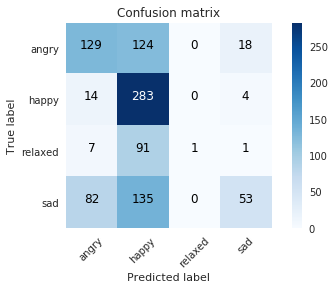

In [180]:
y_pred = clf.predict(X_test_nb)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=cm_labels)
print('Accuracy of Naive-Bayes classifier on test set: {:.2f}'.format(clf.score(X_test_nb, y_test)))

Accuracy of Naive-Bayes classifier on extra test set: 0.40


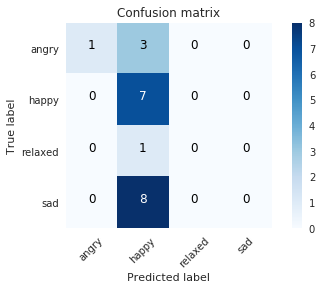

In [181]:
y_pred = clf.predict(X_test_extra_nb)
plot_confusion_matrix(confusion_matrix(y_test_extra, y_pred), classes=cm_labels)
print('Accuracy of Naive-Bayes classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra_nb, y_test_extra)))

# Conclusions

Having a bigger dataset at our disposal may certainly make our predictions more stable. However EmoInt is probably too much different from what we have classify (tweets vs lyrics) and it may not improve our predictive abilities at all.

# References
[EmoInt](http://saifmohammad.com/WebDocs/TweetEmotionIntensities-starsem2017.pdf)